# Q1: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [7]:

def gibbs_sampler(n, m, s):
    x = stats.norm(loc=m, scale=s).rvs(size=n)  # Generate n samples from N(m, s)
    C, G = 2, 10000  # Number of chains, number of Gibbs samples
    theta, tau = np.zeros([C, G]), np.zeros([C, G])
    
    theta[:, 0] = 1000  # Initialization of theta

    for c in range(C):  # Loop over chains
        for g in range(1, G):  # Loop over samples
            # Sample tau from Gamma distribution
            tau_shape = n / 2 + 1  # Shape parameter (α)
            tau_scale = 1 / ((0.5 * ((x - theta[c, g-1])**2).sum()))  # Scale is 1/rate

            tau[c, g] = stats.gamma(a=tau_shape, scale=tau_scale).rvs()

            # Sample theta from Normal distribution
            theta_mean = x.mean()
            theta_sd = np.sqrt(1 / (tau[c, g] * n))  # Corrected scale for Normal
            
            theta[c, g] = stats.norm(loc=theta_mean, scale=theta_sd).rvs()

    return theta, tau

In [8]:
# Call the Gibbs sampler
n, m, s = 100, 0, 2  # Example input
theta, tau = gibbs_sampler(n, m, s)

# Define parameters for visualization
C= 2

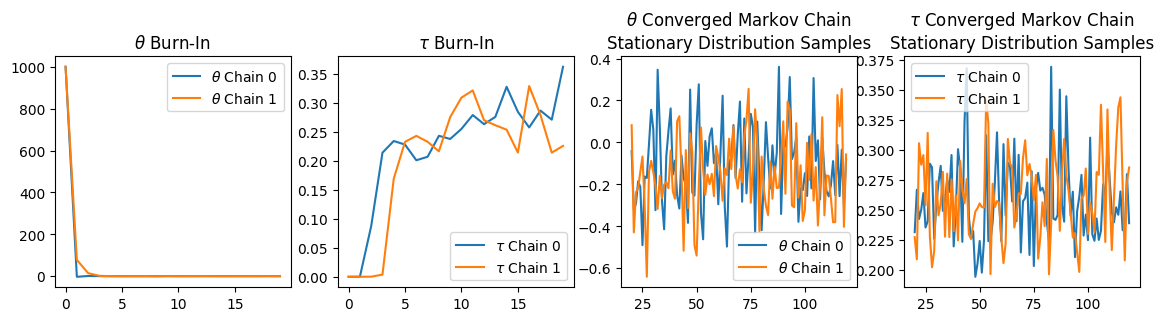

In [21]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();         

# Q2 

Derive the *full conditional distributions* $p(\tau|\theta, \mathbf{x})$ and $p(\theta|\tau, \mathbf{x})$ if $p(\theta)$ is $N(\theta_0, \tau^2_0)$ and $p(\tau) \propto \tau^{\frac{\alpha}{2}-1} e^{- \frac{\lambda}{2} \tau}$. 

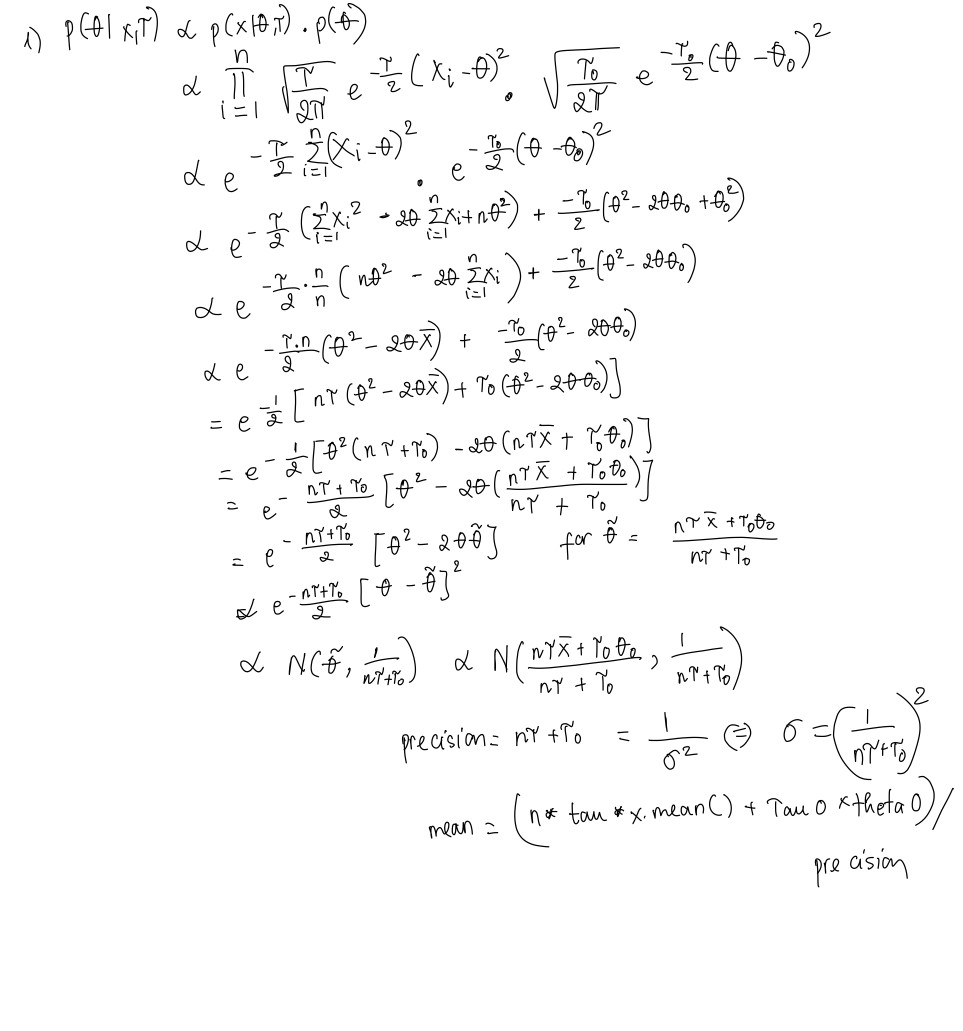

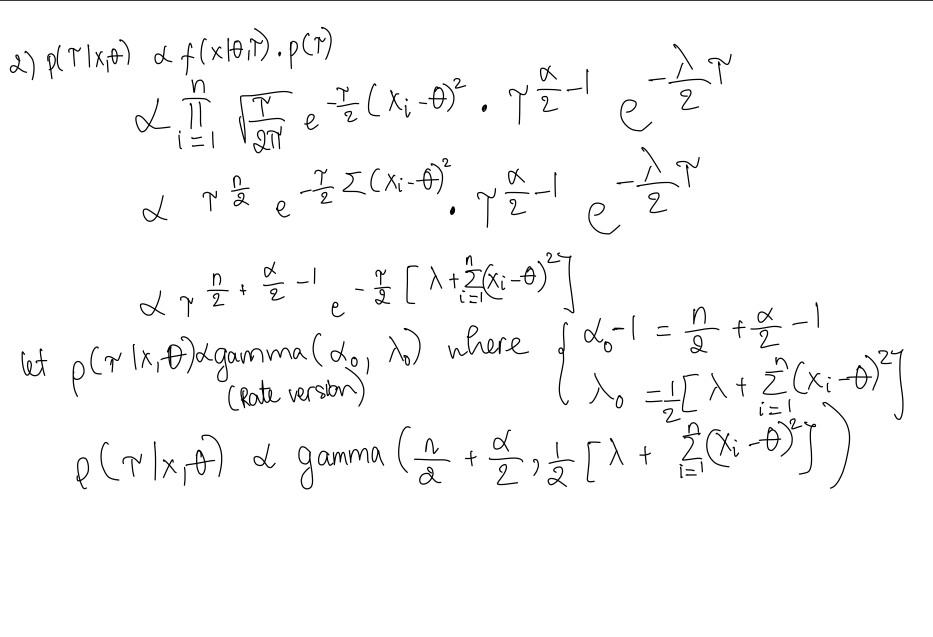

Interprete $\alpha$ and $\lambda$; 

- $\alpha$ and $\lambda$ are hyperparameters of the Gamma prior on $p(\tau)
- $\alpha$  controls the shape (number of prior data points).
- $\lambda$ controls the rate (precision of prior information).

If $\alpha$ and $\lambda$ are large, the prior dominates, and the posterior is heavily influenced by the prior.

If $\alpha$ and $\lambda$ are small, the likelihood dominates and the prosterior relies on the data's information.


### Gibbs sampler: 

In [18]:
def gibbs_sampler_updated(n, m, s, alpha, lambd, theta0, tau0):
    # Data
    x = stats.norm(loc=m, scale=s).rvs(size=n)

    # Parameters
    C, G = 2, 10000  # Chains, Gibbs samples
    theta, tau = np.zeros((C, G)), np.zeros((C, G))
    theta[:, 0] = theta0  # Initialize theta

    # Gibbs Sampling
    for c in range(C):
        for g in range(1, G):
            # Sample tau
            shape = n / 2 + alpha / 2
            rate = 0.5 * (((x - theta[c, g - 1])**2).sum() + lambd)
            tau[c, g] = stats.gamma(a=shape, scale=1 / rate).rvs()

            # Sample theta
            precision = tau[c, g] * n + tau0
            mean = (tau[c, g] * n * x.mean() + theta0*tau0) / precision
            theta[c, g] = stats.norm(loc=mean, scale=np.sqrt(1 / precision)).rvs()

    return theta, tau       

In [19]:
# Example hyperparameters
alpha, lambd = 2, 1
theta0, tau0= 0, 1
n, m, s = 30, 0, 1

# Run Gibbs Sampler
theta_samples, tau_samples = gibbs_sampler_updated(n, m, s, alpha, lambd, theta0, tau0)


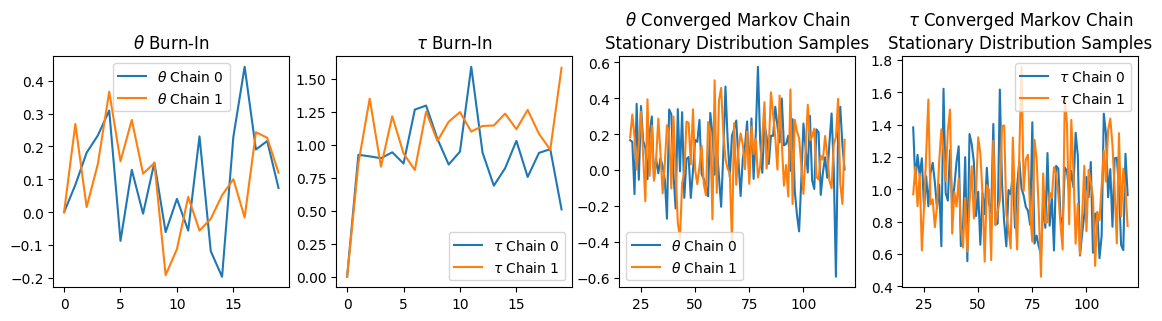

In [22]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta_samples[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau_samples[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta_samples[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau_samples[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();  

# Q3: 

##### **(A) Analogous Derivation for the Multinomial-Dirichlet Specification**

Suppose we have a categorical variable $X$  that takes  $K$ possible values, where  
$$
\theta = (\theta_1, \theta_2, \dots, \theta_K)
$$
 represents the probabilities of each category.

Given $ n$ observations, let  $X_i$ be the outcome of the  i-th trial, and define counts:

$$
x = (x_1, x_2, ..., x_K)
$$

where $x_k$ is the number of times category $k$ was observed, and  

$$
\sum_{k=1}^{K} x_k = n.
$$

### **Likelihood (Multinomial Distribution)**

$$
p(x | \theta) = \frac{n!}{x_1! x_2! \dots x_K!} \theta_1^{x_1} \theta_2^{x_2} \dots \theta_K^{x_K}
$$

### **Prior (Dirichlet Distribution)**

$$
p(\theta) = \frac{1}{B(\alpha)} \prod_{k=1}^{K} \theta_k^{\alpha_k - 1}
$$

where $B(\alpha)$ is the multivariate Beta function.


**Using Bayes' theorem:**

$$
p(\theta | x) \propto p(x | \theta) p(\theta)
$$

**Substituting the formulas for the multinomial likelihood and Dirichlet prior:**
$$
p(\theta | x) \propto \left( \prod_{k=1}^{K} \theta_k^{x_k} \right) \cdot \left( \prod_{k=1}^{K} \theta_k^{\alpha_k - 1} \right)
$$

$$
p(\theta | x) \propto \prod_{k=1}^{K} \theta_k^{x_k + \alpha_k - 1}
$$

This is a **Dirichlet distribution** with updated parameters:

$$
\theta | x \sim \text{Dirichlet}(\alpha_1 + x_1, \alpha_2 + x_2, ..., \alpha_K + x_K)
$$

This confirms that the **Dirichlet prior is conjugate to the multinomial likelihood**.